In [1]:
from readfiles import *
import sys
import numpy.linalg as LA
import copy
from unit import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Writing main Hamiltonian

In [2]:
# Now defining Units and conversion factors. 
h = 6.62607015e-34 # planck's constant in joules second
c = 2.99792458e10 # speed of light in cm per second
e = 1.60217663e-19 # charge of electron in coulombs
hbar = 0.658211951 # in eV-fs or meV-ps or ueV-ns
cm2ev = c*h/e  # conversion factor from 1/cm to eV
cm2mev = cm2ev * 1.e3  # conversion from 1/cm to meV
ev2au = e/4.3597447222071e-18  # converison from eV to atomic mass units
cm2au = cm2ev * ev2au  # conversion from 1/cm to atomic mass units

kB = 8.617333262e-2 # meV/K, Boltzmann constant

In [3]:
free_e_gyro = 28024.9514242E6 # Hz/T gyromagnetic ratio of an electron.
hz2meV = 4.1357E-12 # 1Hz = 4.1357E-15 eV = 4.1357E-12 meV
free_e_gfactor = 2.00231930437378 # free electron g factor 2.00231930437378
alpha = (free_e_gyro*hz2meV)/free_e_gfactor # gyromagnetic ratio/gfactor in meV per tesla
print("alpha in units of meV per tesla = "+str(alpha))
print("hbar is contained in the definition of alpha")

alpha in units of meV per tesla = 0.057884270182028845
hbar is contained in the definition of alpha


In [4]:
eS = jmat(1/2)
eS

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.  0.5]
  [0.5 0. ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j  0.-0.5j]
  [0.+0.5j 0.+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0. ]
  [ 0.  -0.5]])

In [5]:
sigma_vec = [sigmax(), sigmay(), sigmaz()]
sigma_vec

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 1.]
  [1. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]]]

In [6]:

# NOTE: using the pauli vector instead of spin half operators. Defining a single spin half operators
#eS = jmat(1/2) # list of electronic spin operators [Sx, Sy, Sz] 
# NOTE: In qutip, the eigensolver transforms the Matrix with eigen values in ascending order.

# Loading the gtensor for the basic Hamiltonian.
fname = 'data files/gtensor.dat' # loading the gtensor, hyperfine tensor, and ztensor. 
gtensor, hfc, zfs = read_g(fname)

# Defining External magnetic field vector
Bfield = 1 # Tesla
print("applied magnetic field is ", Bfield, " Tesla")

Bvector = np.zeros(3)
Bvector[0] = 0
Bvector[1] = 0
Bvector[2] = Bfield


# Defining spin Hamiltonian
H = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H is None:
            H = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * Bvector[j]# instead of spin 1/2 matrices 

print('Spin zeeman hamiltonian')
#H.tidyup()
H

applied magnetic field is  1  Tesla
Spin zeeman hamiltonian


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 5.76003884e-02+0.00000000e+00j  6.38260905e-05+2.56166838e-05j]
 [ 6.38260905e-05-2.56166838e-05j -5.76003884e-02+0.00000000e+00j]]

In [7]:
energies, estates  = (-H).eigenstates() # the eigenstates are in acending order, the -ve reintroduces the decending order
energies, estates

(array([-0.05760043,  0.05760043]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[-9.99999822e-01+0.j        ]
         [-5.54041893e-04+0.00022237j]]                              ,
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
        Qobj data =
        [[ 5.96999835e-04+0.j        ]
         [-9.28043463e-01+0.37247144j]]                              ],
       dtype=object))

In [8]:
H = H.transform(estates)
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.05760043  0.        ]
 [ 0.         -0.05760043]]

### At this point we should tranform the coupings to new eigen basis as well. but since the new basis are very close to the prevous one, I think we can ommitt this step with negligible error

# Loading and visualizing frequencies and gtensor derivative i.e. dgx

In [9]:
# Loading the couplings and frequencies
freq, dgx = get_phonon('data files/spin_phonon.dat')
freq = freq*cm2mev
print("the intra vibrations of a single molecule are the harmonic frequencies here in meV")

number of vibs= 190
the intra vibrations of a single molecule are the harmonic frequencies here in meV


In [10]:
dgx[0]

array([[-2.4308993e-03, -3.6944117e-03,  1.8978486e-03],
       [-2.8236532e-03,  1.5009815e-03,  8.7550132e-05],
       [ 1.0964913e-03,  5.0411135e-04,  3.4037204e-04]])

In [11]:
freq/cm2mev

array([  12.8 ,   26.32,   42.4 ,   43.09,   43.64,   68.84,   76.09,
         76.65,   76.92,   82.92,   83.56,  103.44,  134.89,  143.88,
        145.41,  146.6 ,  147.71,  156.8 ,  178.5 ,  181.71,  202.14,
        215.87,  226.73,  240.07,  241.75,  243.96,  245.31,  245.7 ,
        252.06,  271.68,  287.44,  289.37,  296.58,  305.96,  306.44,
        320.06,  321.25,  342.52,  342.85,  349.94,  352.65,  359.74,
        375.24,  375.42,  377.48,  389.13,  396.28,  396.85,  397.32,
        405.39,  431.7 ,  433.13,  435.32,  441.36,  468.06,  500.09,
        500.15,  501.68,  508.62,  540.97,  541.38,  541.82,  549.79,
        551.57,  560.67,  561.72,  568.15,  571.83,  597.24,  605.11,
        605.69,  620.32,  647.11,  667.29,  671.07,  676.64,  682.97,
        689.03,  700.24,  715.45,  715.95,  725.25,  732.82,  734.06,
        737.55,  741.2 ,  742.53,  748.2 ,  752.43,  757.7 ,  760.2 ,
        764.18,  767.13,  769.  ,  809.2 ,  812.8 ,  820.72,  824.97,
        837.39,  844

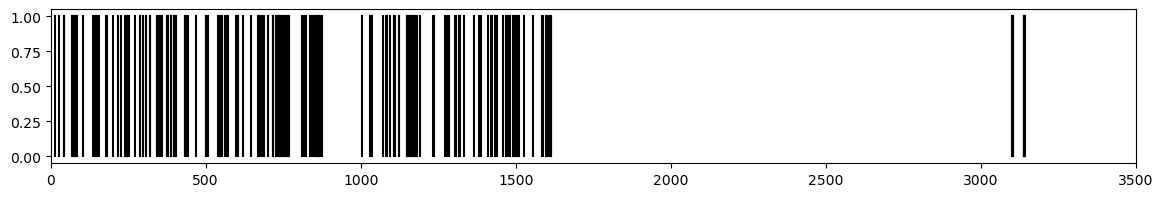

In [12]:
plt.figure(figsize=(14, 2))
plt.xlim([0, 3500])
for i in range(len(freq)):
    plt.plot([freq[i]/cm2mev,freq[i]/cm2mev], [0,1], 'k')
plt.show()

In [13]:
test = np.array([[1,2,3], [4,5,6]])
np.linalg.norm(test)

9.539392014169456

In [14]:
np.sqrt(np.sum(np.array([[1,2,3], [4,5,6]])**2))

9.539392014169456

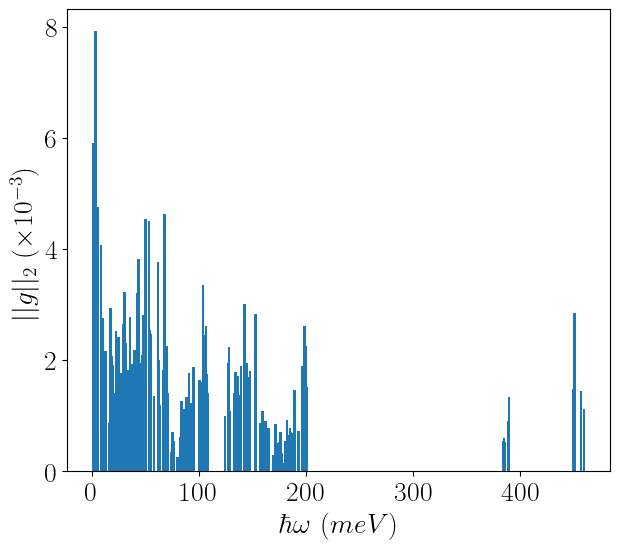

In [15]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq, np.array(zeeman_l2_norm)*1e3, width = 2.5)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$\hbar \omega \ (meV)$ ')
plt.ylabel(r'$||g||_2 \ (\times 10^{-3})$')
plt.show()

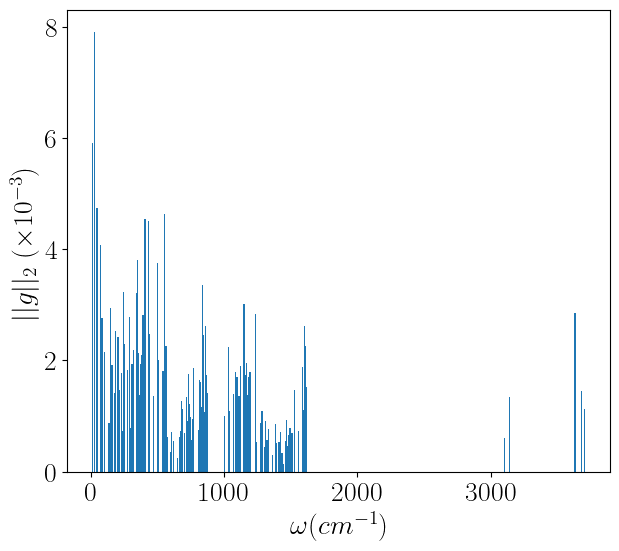

In [16]:
zeeman_l2_norm = []

for k in range(len(freq)):
    zeeman_l2_norm.append(np.linalg.norm(dgx[k,:]))

plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 6))
plt.bar(freq/cm2mev, np.array(zeeman_l2_norm)*1e3, width = 10)
#plt.title(r"Zeeman coupling $l_2$ norm $V = \sum_{ij} |\frac{\partial g_{ij}}{\partial x}\delta x|^2$")
plt.xlabel('$ \omega (cm^{-1})$ ')
plt.ylabel(r'$||g||_2 \ (\times 10^{-3})$')
plt.show()

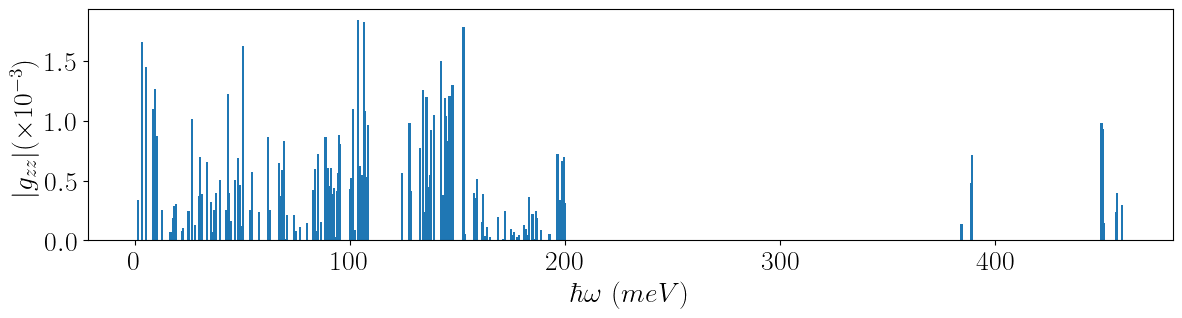

In [18]:
plt.rcParams['text.usetex'] = True 
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(14, 3))
plt.bar(freq, np.abs(np.array(dgx[:,2,2])*1e3), width = 1)
plt.xlabel('$\hbar \omega \ (meV)$ ')
plt.ylabel(r'$|g_{zz}|  (\times 10^{-3})$')
plt.show()

### Converting derivatives of gtensor into couplings $\tilde c$ with Pauli matrices

$$
gcoupS= \tilde c_{\alpha k} = \alpha \frac{\partial g_{\alpha z}}{\partial q_k} B_z (1/2)
$$

Note: this last 1/2 is comming from converting spin half opertors (S) to pauli matrices

In [17]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# NOTE: this coupling also has the harmonic bath displacement operator contained in it. therefore, it has units of meV.
print('First 5 new couplings \n', gcoupS[:5])
print('these couplings are for the Pauli X, Y, Z operators.')

First 5 new couplings 
 [[ 5.49277906e-05  2.53388775e-06  9.85109356e-06]
 [-2.91232116e-05  8.43397839e-06 -4.81645693e-05]
 [ 6.26718348e-06 -2.99584932e-05 -2.30264090e-05]
 [-4.29811023e-06 -2.40631527e-05 -4.20601376e-05]
 [-2.17794186e-05  9.84837445e-06 -3.23478314e-05]]
these couplings are for the Pauli X, Y, Z operators.


# Understanding of the couplings.

$$
H_{int} = \sum_i A_i \otimes C_i = \sum_i \sigma_i C_i
$$

where $A_i$ are system operators i.e. $\sigma_i$ Pauli matrices, and $C_i$ are linear sum of phonon displacement operators. 
i.e. 
$$
C_i = \sum_j c^{(i)}_j u_j
$$

In the case of Zeeman Hamiltonian, the spin-phonon interaction is consequence of variation in g-tensor as a result of atomic displacements due to molecular vibrations. Therefore, 
$$
H_{int} = \sum_i \sigma_i [\frac{\alpha}{2}\sum_{jk} \frac{\partial g_{ik}}{\partial u_j} B_k u_j] = \sum_i \sigma_i (\sum_{j}c^i_j u_j) =\sum_i \sigma_i C_i
$$
where $B_k$ are elements of magnetic field vector, $g^j$ is the g-tensor, $\alpha$ contains gyromagnetic ratio and acts like a conversion factor for the entire term to energy (meV/T). Finally 
$$
c^i_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j} B_k 
$$

### NOW instead of $\frac{\partial g_{ik}}{\partial u_j}$, we have $\frac{\partial g_{ik}}{\partial u_j}\Delta u_j = dgx$

so one way forward is to assume: 
$$
c^i_j u_j = \frac{\alpha}{2} \sum_{k} \frac{\partial g_{ik}}{\partial u_j}\Delta u_j B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = \frac{\alpha}{2} \sum_{k} dgx B_k \frac{u_j}{\Delta u_j} = gcoup \frac{u_j}{\Delta u_j}
$$

Now this means that there is this puzzle of what the value for $\Delta u_j$ happens to be; can I take it as some normalization factor?

### Defining spectral densities

In [18]:
def shape_normal(w, w0, sigma):
    '''
    this function returns a Gaussian/Normal distribution centered at w0 with std sigma
    '''
    return np.exp(-0.5*((w-w0)/sigma)**2)/(sigma*np.sqrt(2*np.pi))


def lorentzian(w, w0, sigma):
    '''
    this function returns a lorentzian profile centered at 'w0' with thickness 'sigma'
    NOTE: sigma is related to the lifetime of the mode by tau = hbar/sigma
    '''
    return  sigma/(np.pi*(sigma**2 + (w-w0)**2))

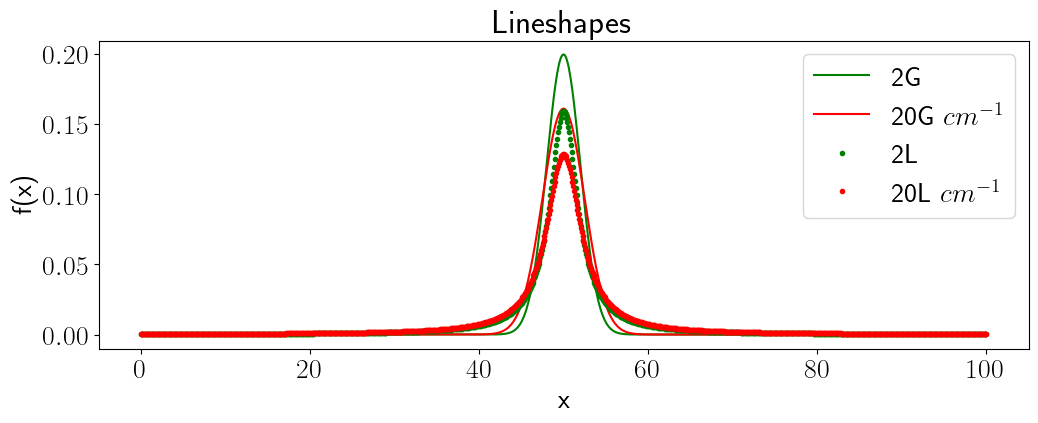

In [19]:
# lets test it out. 
x = np.linspace(0, 100, 1000)
y1 = [shape_normal(w, w0=50, sigma=1) for w in x]
y2 = [shape_normal(w, w0=50, sigma=2) for w in x]
y20cm = [shape_normal(w, w0=50, sigma=20*cm2mev) for w in x]

y1l = [lorentzian(w, w0=50, sigma=1) for w in x]
y2l = [lorentzian(w, w0=50, sigma=2) for w in x]
y20cml = [lorentzian(w, w0=50, sigma=20*cm2mev) for w in x]



plt.figure(figsize=(12,4))
#plt.plot(x,y1, 'b')
plt.plot(x,y2, 'g')
plt.plot(x,y20cm, 'r')
#plt.plot(x,y1l, 'b.-')
plt.plot(x,y2l,'g.')
plt.plot(x,y20cml,'r.')
plt.title("Lineshapes")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(['2G','20G $cm^{-1}$','2L','20L $cm^{-1}$'])
plt.show()

In [20]:
def spectral_density_quantum(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    n = n_thermal = pop of harmonic oscillator mode with frequency ‘w’, at the temperature described by ‘w_th’ where 𝜔_th = 𝑘𝐵 𝑇/ℏ
    NOTE: freqs and couplings must be passed in energy units i.e. meV. 
    units of S(w) are [(meV)^2 s]

    Note: It requires cij tilde converts it into cij by division with sqrt(hbar/2wj) and then computes the spectral density
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*T/hbar # temperature defined as frequency
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy / length
        nj = n_thermal(wj,w_th)
        #sigma = 0.1*wj
        if shape=='G':
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*shape_normal(w, wj, sigma) + nj*shape_normal(w, -wj, sigma) )
        else:
            S += np.pi*hbar*(cj**2/wj)*( (nj+1)*lorentzian(w, wj, sigma) + nj*lorentzian(w, -wj, sigma) )
    return S

def spectral_density_classical(w, freqs, coup, T=5, sigma=2, shape='L'):
    '''
    for full formula see the cell below
    Units of S(w) are energy (meV) if freqs and couplings are in frequency units.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    S = 0
    for j in range(len(freqs)):
        wj = freqs[j]/hbar
        cj = coup[j]/np.sqrt(hbar/(2*wj)) # energy/length
        if shape=='G':
            S += np.pi*kB*T*(cj**2/wj**2)*(shape_normal(w, wj, sigma) + shape_normal(w, -wj, sigma))
        else:
            S += np.pi*kB*T*(cj**2/wj**2)*(lorentzian(w, wj, sigma) + lorentzian(w, -wj, sigma))
    return S

NOTE: The quantum spectral density follows the equation 
Starting from the time domain description: 
$$
S(t) = \sum_j \frac{\hbar c_j^2}{2\omega_j} [(n_j +1)e^{-i\omega_j t} + n_j e^{i\omega_j t}]
$$
we transform to the fourier domain using definition
$$
2\pi \delta(\omega\pm \omega_j) = \int_{-\infty}^{-\infty} e^{ i (\omega \pm \omega_j) t} dt
$$
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) \delta(\omega - \omega_j)+n_j\delta(\omega+\omega_j)  ]
$$
where $n(\omega_j)$ and the delta shapes will be replaced by the Gaussian
$$
S(\omega) = \pi \hbar \sum_j \frac{c_j^2}{\omega_j} [(n_j+1) G(\omega_j, \sigma)+n_jG(-\omega_j, \sigma)  ]
$$

in the high temperature limit $n_j = \frac{k_B T}{\hbar \omega_j} >> 1$. This leads to 
$$
S(\omega) = \pi k_B T \sum_j \frac{c_j^2}{\omega_j^2} [G(\omega_j, \sigma) + G(-\omega_j, \sigma)  ]
$$

which is the same as classical spectral density. NOTE: time domain classical funciton is 
$$
S(t) = k_B T \sum_j \frac{c_j^2}{\omega_j^2} cos(\omega_j t)
$$



### Implementation detail. 
From the dimensional analysis fo the generic interaciton Hamiltonian
$$
H_{int} = \sum_{ij} c_{ij} (\sigma_i \otimes \hat{X}_j)
$$
$c$'s must be in $energy/[X]$ untis. Using definition $X_j = \sqrt{\frac{\hbar}{2\omega_j}}(a^\dagger_j + a_j)$

our couplings will have to be re formed as $c_{new} = c \times (\frac{\hbar}{2\omega_j})^{-1/2}$

new units of couplings are $[c_{new}] = \frac{\sqrt{eng}}{s}$. 

Consequently, $[S(\omega)] = eng^2 s$ and $ [S(\omega)/\hbar^2] = 1/s$

In [24]:
Np = len(freq)
gcoupS = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupS[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:41: RuntimeWarning: overflow encountered in exp
  if (w_th > 0) and np.exp(w / w_th) != 1.0:
/home/nyoun/anaconda3/lib/python3.11/site-packages/qutip/utilities.py:42: RuntimeWarning: overflow encountered in exp
  return 1.0 / (np.exp(w / w_th) - 1.0)


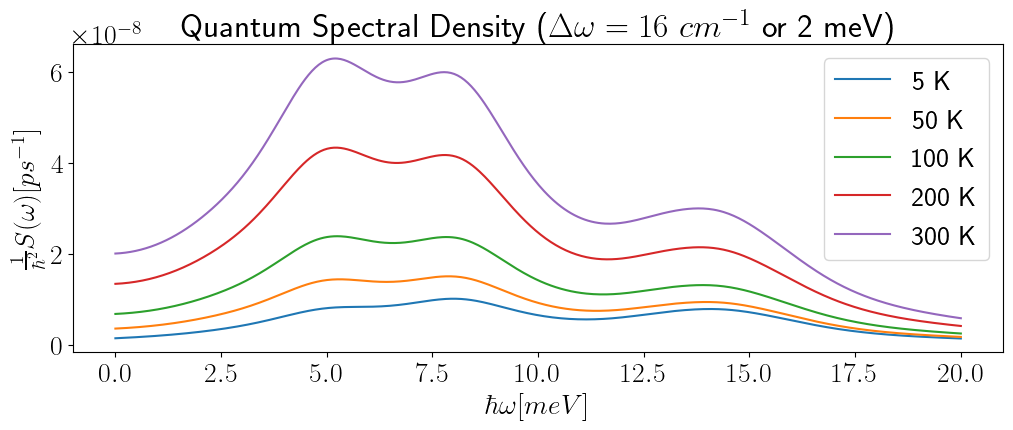

In [95]:
x = np.linspace(0, 20, 500)
y5q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300q = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]
plt.figure(figsize=(12,4))
plt.plot(x,y5q)
plt.plot(x,y50q)
plt.plot(x,y100q)
plt.plot(x,y200q)
plt.plot(x,y300q)
plt.title(r"Quantum Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

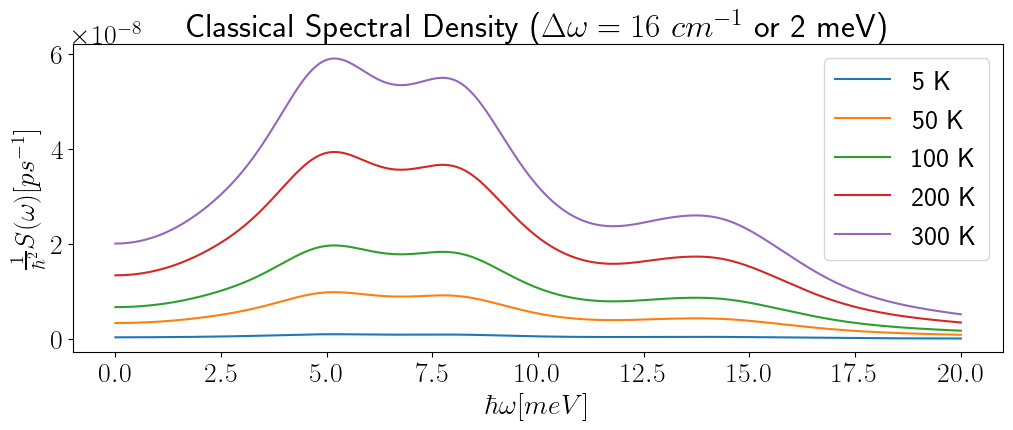

In [96]:
x = np.linspace(0, 20, 500)
y5c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2 for w in x]
y50c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=50, sigma=2)/hbar**2 for w in x]
y100c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=100, sigma=2)/hbar**2 for w in x]
y200c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=200, sigma=2)/hbar**2 for w in x]
y300c = [spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2)/hbar**2 for w in x]

plt.figure(figsize=(12,4))
plt.plot(x,y5c)
plt.plot(x,y50c)
plt.plot(x,y100c)
plt.plot(x,y200c)
plt.plot(x,y300c)
plt.title(r"Classical Spectral Density ($\Delta \omega = 16 \ cm^{-1}$ or 2 meV) ")
plt.xlabel(r"$\hbar \omega [meV]$")
plt.ylabel(r"$\frac{1}{\hbar^2}S(\omega) [ps^{-1}]$")
plt.legend(['5 K','50 K','100 K', '200 K', '300 K'])
plt.show()

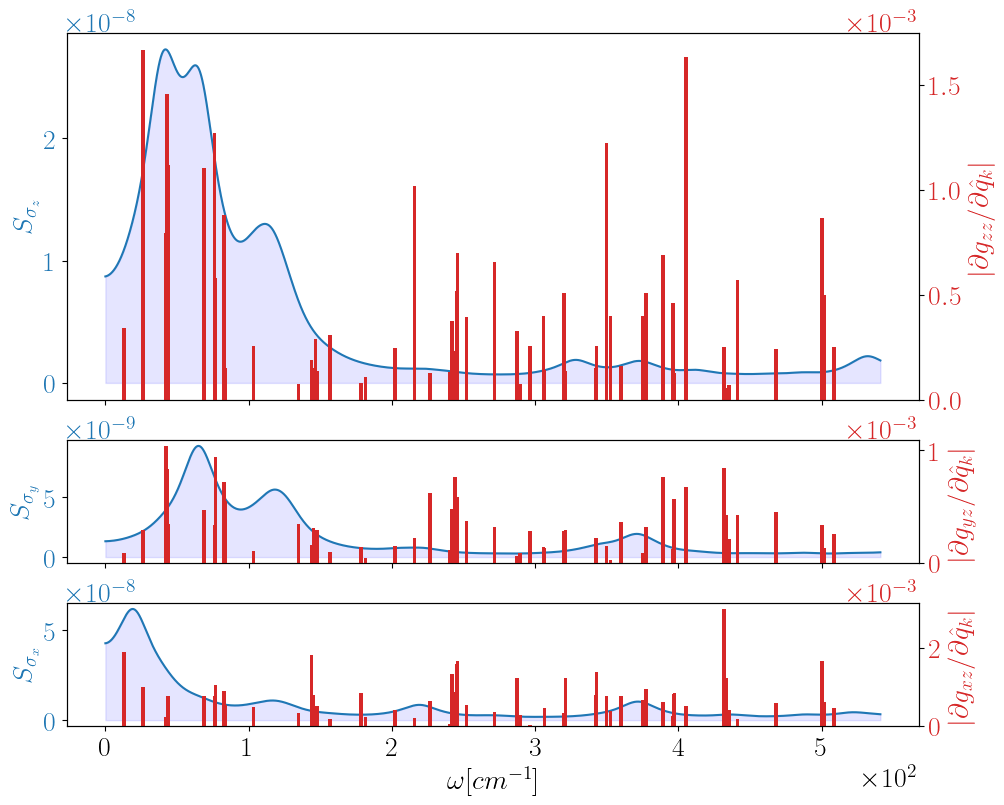

In [25]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [3, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

highfreq = 59

xspec = np.linspace(0, freq[highfreq], 5000)
yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S_{\sigma_z}$", color=color)
#axs[0].set_ylim([0, 5])
axs[0].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor=color)

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,2,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$S_{\sigma_y} $", color=color)
#axs[1].set_ylim([0, 5])
axs[1].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor=color)

ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,1,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

yspec = [spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=300, sigma=2) for w in xspec]
color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$S_{\sigma_x}$", color=color)
#axs[2].set_ylim([0, 5])
axs[2].plot(xspec/cm2mev,np.array(yspec),color=color)
axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor=color)

ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis
gnorm = np.array([np.sqrt(dgx[i,0,2]**2) for i in range(len(freq[:highfreq]))])

color = 'tab:red'
ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat q_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

## At this point it is important to note that the useful values of w at which we need S are w=0 and w=energy split

In [26]:
w_split = energies[1]- energies[0]
print(r"hbar*w_split= ", w_split, " meV, ","w_split/hbar= ", w_split/hbar, " freq")

hbar*w_split=  0.11520085882875064  meV,  w_split/hbar=  0.17502091636854927  freq


# Redfield with full set of modes for T1 and T2

## T1 Dynamics

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.36s. Est. time left: 00:00:00:00
40.0%. Run time:   0.48s. Est. time left: 00:00:00:00
50.0%. Run time:   0.60s. Est. time left: 00:00:00:00
60.0%. Run time:   0.72s. Est. time left: 00:00:00:00
70.0%. Run time:   0.84s. Est. time left: 00:00:00:00
80.0%. Run time:   0.96s. Est. time left: 00:00:00:00
90.0%. Run time:   1.08s. Est. time left: 00:00:00:00
Total run time:   1.20s


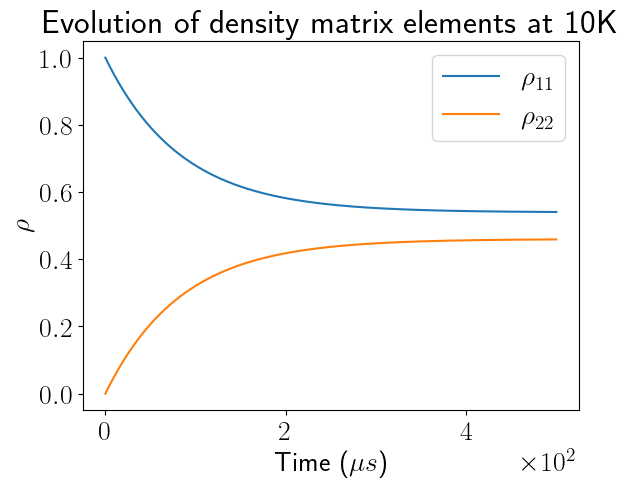

In [47]:
# Single Run
Temp = 10

tlist = np.linspace(1, 500e6, 2000) # in ps

specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=Temp, sigma=2, shape='G')/hbar**2
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=Temp, sigma=2, shape='G')/hbar**2
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=Temp, sigma=2, shape='G')/hbar**2

e_ops = []

aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]


rho0 = basis(2,0)*basis(2,0).dag()
results1 = brmesolve(-H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho11_vals = np.array([results1.states[k].full()[0,0] for k in range(len(tlist))])
rho22_vals = np.array([results1.states[k].full()[1,1] for k in range(len(tlist))])

plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, np.abs(rho22_vals))
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K")
plt.legend([r"$\rho_{11}$", r"$\rho_{22}$"])
plt.show()

In [48]:
kB = 8.617333262e-2 # meV/K, Boltzmann constant
w_th = kB*Temp/hbar # temperature defined as frequency
nth = n_thermal(energies[1]/hbar,w_th)
thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
thermal_rho_11

0.5167044116352179

In [49]:
# curve fitting to extract T1.
def t1_func_thermal(x,t1):
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    w_th = kB*Temp/hbar # temperature defined as frequency
    nth = n_thermal(energies[1]/hbar,w_th)
    thermal_rho_11 = thermal_dm(2, nth, method='operator').full()[0].real[0]
    return (1-thermal_rho_11)*np.exp(-x/t1)+thermal_rho_11

def t1_func(x,t1, xinf):
    return (1-xinf)*np.exp(-x/t1)+xinf
    
def t1_func_classical(x,t1):
    return (1/2)*np.exp(-x/t1) + (1/2)

In [50]:
fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_vals))
fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_vals))
f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_vals))
f

array([83.8042354 ,  0.53961729])

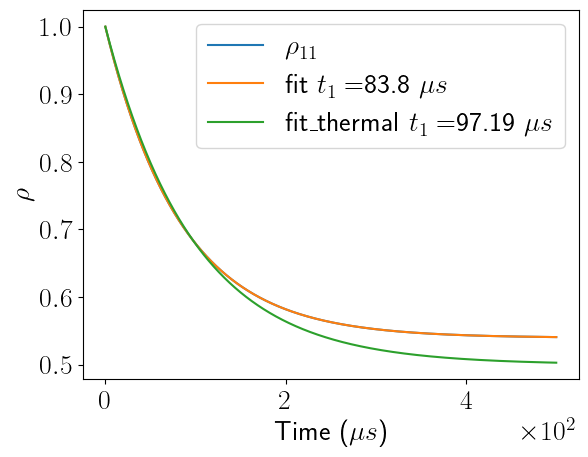

In [51]:
fit_thermal = np.array([t1_func_classical(k, fthermal)  for k in tlist/1e6])
fit_classical = np.array([t1_func_classical(k, fclassical)  for k in tlist/1e6])
fit_f = np.array([t1_func(k, f[0],f[1])  for k in tlist/1e6])
plt.figure()
plt.plot(tlist/1e6, np.abs(rho11_vals))
plt.plot(tlist/1e6, fit_f)
plt.plot(tlist/1e6, fit_thermal)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
#plt.title("Evolution of densitymatrix elements at "+str(Temp)+"K, T1 = "+str(f))
plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
plt.show()

### Now checking the respose of T1 from 5K to 300 K

In [52]:
# Temperature Scan, multiple runs
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 10000e6, 2000) # in ps

In [ ]:
# QUANTUM

t1_list = np.array([])
t1d_list = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    t1_list = np.append(t1_list, t1)
    t1d_list = np.append(t1d_list, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit_thermal = np.array([t1_func_classical(m, fthermal)  for m in tlist/1e6])
    #fit_classical = np.array([t1_func_classical(m, fclassical)  for m in tlist/1e6])
    fit_f = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit_f)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list', t1_list)
np.save('saved variables/t1d_list', t1d_list)
print(t1_list) 

In [ ]:
# CLASSICAL

t1_list = np.array([])
t1d_list = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    #t1, t1d = f[0], df[0,0]
    t1, t1d = f, df
    t1_list = np.append(t1_list, t1)
    t1d_list = np.append(t1d_list, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, t1)  for m in tlist/1e6])
    fit = np.array([t1_func_classical(m, t1)  for m in tlist/1e6])
    #fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(t1,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_classical', t1_list)
np.save('saved variables/t1d_list_classical', t1d_list)
print(t1_list) 

In [69]:
t1_list_quantum = np.load('saved variables/t1_list.npy')
t1d_list_quantum = np.load('saved variables/t1d_list.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')
plt.figure(figsize=(12,6))
plt.errorbar(Temp_list, t1_list_quantum, yerr = t1d_list_quantum, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend(['Quantum ', 'Classical'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")


NameError: name 'Temp_list' is not defined

<Figure size 1200x600 with 0 Axes>

In [70]:
gcoupTest

array([[ 2.02933965e-05,  9.36159788e-07,  3.63954468e-06],
       [-7.50350054e-06,  2.17298704e-06, -1.24094443e-05],
       [ 1.27220494e-06, -6.08141489e-06, -4.67423864e-06],
       [-8.65479725e-07, -4.84542501e-06, -8.46934916e-06],
       [-4.35784226e-06,  1.97056052e-06, -6.47247520e-06],
       [-3.48534544e-06, -2.14602572e-06, -5.08073767e-06],
       [ 1.12041506e-06, -1.48223428e-06,  5.57615431e-06],
       [ 3.33235607e-06, -8.56170599e-07, -2.53725563e-06],
       [ 4.58306456e-06, -4.08052357e-06,  1.83823319e-06],
       [ 3.71030849e-06, -3.00513658e-06,  3.68791488e-06],
       [-2.23010119e-06,  2.30719407e-06, -6.37808993e-07],
       [-1.83105511e-06, -3.92338444e-07, -9.57292738e-07],
       [ 1.04192761e-06, -1.14234363e-06, -2.47792665e-07],
       [-5.75619726e-06,  5.11439180e-07,  5.94048185e-07],
       [ 2.51427159e-06, -9.81301642e-07,  4.73206616e-07],
       [ 1.22584054e-06, -4.23255288e-07, -9.04834898e-07],
       [ 1.61790728e-06, -8.99632460e-07

In [71]:
# test 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

# QUANTUM

t1_list_test = np.array([])
t1d_list_test = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,0], T=temp, sigma=2, shape='L')/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,1], T=temp, sigma=2, shape='L')/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupTest[:,2], T=temp, sigma=2, shape='L')/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 


    fthermal, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    fclassical, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    t1_list_test = np.append(t1_list_test, t1)
    t1d_list_test = np.append(t1d_list_test, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit_thermal = np.array([t1_func_classical(m, fthermal)  for m in tlist/1e6])
    #fit_classical = np.array([t1_func_classical(m, fclassical)  for m in tlist/1e6])
    fit_f = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit_f)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
#np.save('saved variables/t1_list_test', t1_list_test)
#np.save('saved variables/t1d_list_test', t1d_list_test)
print(t1_list_test) 

NameError: name 'Temp_list' is not defined

In [67]:
print(np.load('saved variables/t1_list.npy'))

[127.16040333 102.5430231   64.94536042  46.07117922  35.42892798
  28.70145065  24.09100883  20.74323741  18.20558043  16.21740304
  14.61852519  12.20761916  10.47726811   9.1755132    8.16091462
   7.34802424   6.6822006    6.12688267   5.65669649   5.25346895
   4.90386273   4.59785276]


In [ ]:
# testing t1 dynamics at 0.345 T
# Defining External magnetic field vector

B345 = np.zeros(3)
B345[0] = 0
B345[1] = 0
B345[2] = 0.345

# Defining spin Hamiltonian
H345 = None

# 1) Zeeman interaction
for i in range(3):
    for j in range(3):
        if H345 is None:
            H345 = alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * B345[j] # notice this 1/2 here. its because i am using pauli matrices 
        else:
            H345 += alpha * gtensor[i][j] *(1/2)* sigma_vec[i] * B345[j]# instead of spin 1/2 matrices 

H345

#### Running simulation

In [ ]:
# QUANTUM
tlist = np.linspace(1, 10e6, 100000) # in ps
t1_list_345mT = np.array([])
t1d_list_345mT = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H345/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar = True)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    

    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    print('saturation value difference', f[1]-rho11_k[-1])
    t1, t1d = f[0], df[0,0]
    #t1, t1d = f, df
    t1_list_345mT = np.append(t1_list_345mT, t1)
    t1d_list_345mT = np.append(t1d_list_345mT, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_345mT', t1_list_345mT)
np.save('saved variables/t1d_list_345mT', t1d_list_345mT)
print(t1_list_345mT)  

In [ ]:
# Classical
tlist = np.linspace(1, 10e6, 100000) # in ps
t1_list_345mT_classical = np.array([])
t1d_list_345mT_classical = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    print(temp)
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H345/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops, progress_bar = True)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    

    #f, df = curve_fit(t1_func_thermal, tlist/1e6, np.abs(rho11_k))
    f, df = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    #f, df = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))
    #print('saturation value difference', f[1]-rho11_k[-1])
    #t1, t1d = f[0], df[0,0]
    t1, t1d = f, df
    t1_list_345mT_classical = np.append(t1_list_345mT_classical, t1)
    t1d_list_345mT_classical = np.append(t1d_list_345mT_classical, t1d)
    ##########################################################################################################################
    ################## PLOTTING ################################################
    #fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    fit = np.array([t1_func_classical(m, f)  for m in tlist/1e6])
    #fit = np.array([t1_func(m, f[0],f[1])  for m in tlist/1e6])
    plt.figure()
    plt.plot(tlist/1e6, np.abs(rho11_k))
    plt.plot(tlist/1e6, fit)
    #plt.plot(tlist/1e6, fit_thermal)
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel(r"$\rho$")
    plt.legend([r"$\rho_{11}$", r"fit $t_1 = $"+str(np.round(f,2)[0])+r"$\ \mu s$", r"fit_thermal $t_1 = $"+str(np.round(fthermal,2)[0])+r"$\ \mu s$"])
    plt.show()
    ############################################################################################################################
np.save('saved variables/t1_list_345mT_classical', t1_list_345mT_classical)
np.save('saved variables/t1d_list_345mT_classical', t1d_list_345mT_classical)
print(t1_list_345mT)  

#### Simulation done

In [ ]:
tlist = np.linspace(1, 10000e6, 2000) # in ps

In [ ]:
#tlist = np.linspace(1, 10e6, 100000) # in ps

t1exp = np.array([14163.72734, 6951.95423, 2691.61351,225.3970881,89.17022735,41.0253116,23.92805806,18.87486711,10.77391862,
                  8.873229094,4.171377424,1.143754573])
t2exp = np.array([2.709966603,3.084314127,3.362185823,3.290454844,3.018511437,2.829407455,2.540192367,2.330255261,2.047428917,
                  1.798929603,1.449961246, 0.84569149])
temp_exp = np.array([4.292624643, 9.998683733, 24.90051857, 39.95789327, 59.68654518, 79.87897033, 99.98683733, 109.4868393, 
                     149.3539422, 179.0832077, 198.9289628, 298.5702735])

t1_list_345mT = np.load('saved variables/t1_list_345mT.npy')
t1d_list_345mT = np.load('saved variables/t1d_list_345mT.npy')

t1_list_345mT_classical = np.load('saved variables/t1_list_345mT_classical.npy')
t1d_list_345mT_classical = np.load('saved variables/t1d_list_345mT_classical.npy')

plt.figure(figsize=(12,6))
plt.plot(Temp_list, t1_list_345mT,'-o')#, yerr = t1d_list_345mT, fmt='-o')
plt.plot(temp_exp, t1exp,'-o')
plt.plot(Temp_list, t1_list_345mT_classical,'-o')

plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule at 345 mT")
plt.legend(['T1 quantum (L)', 'T1 exp', 'T1 classical'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")

In [29]:
plt.figure(figsize=(12,6))
plt.plot(Temp_list, t1_list_test,'-o')
plt.plot(temp_exp, t1exp,'-o')

plt.xscale('log')
plt.yscale('log')
plt.title(r"$T_1$ as a function of temperature for single molecule at 345 mT")
plt.legend(['T1 test quantum (L)', 'T1 exp'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")

NameError: name 'Temp_list' is not defined

<Figure size 1200x600 with 0 Axes>

## T2 Dynamics

In [30]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()
rho0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

In [31]:
tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()

e_ops = []
specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=Temp, sigma=2)
specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=Temp, sigma=2)
specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=Temp, sigma=2)
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops, progress_bar=True)

rho12 = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # 12 element of rho vs time 

NameError: name 'Temp' is not defined

In [ ]:
def t2_func(x,t2):
    return np.exp(-x/t2)

In [32]:
t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12))
t2

NameError: name 't2_func' is not defined

In [ ]:

fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(t2))
plt.legend([r"$\rho_{12}$", r"fit"])
plt.show()

In [ ]:
fit = np.array([t2_func(k,t2)  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.real(rho12))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp)+"K , T2="+str(np.round(t2,3)))
plt.legend([r"$\rho_{12}$", r"fit "])
plt.show()

In [ ]:
# Temperature Scan 

t2_list = np.array([])
t2d_list = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=temp, sigma=2)
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=temp, sigma=2)
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=temp, sigma=2)
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list = np.append(t2_list, t2)
    t2d_list = np.append(t2d_list, t2d)


np.save('saved variables/t2_list', t2_list)
np.save('saved variables/t2d_list', t2d_list)
print(t2_list)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

In [ ]:
# Temperature Scan 

t2_list_classical = np.array([])
t2d_list_classical = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,0]/hbar, T=temp, sigma=2)
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,1]/hbar, T=temp, sigma=2)
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq/hbar, coup=gcoupS[:,2]/hbar, T=temp, sigma=2)
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list_classical = np.append(t2_list_classical, t2)
    t2d_list_classical = np.append(t2d_list_classical, t2d)


np.save('saved variables/t2_list_classical', t2_list_classical)
np.save('saved variables/t2d_list_classical', t2d_list_classical)
print(t2_list)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list_classical[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

In [ ]:
#t2_list = np.load('t2_list.npy')
#t2d_list = np.load('t2d_list.npy')

In [ ]:
# plotting all curves and fittings to check if t2 calculations went properly

plt.figure()
for i in range(len(Temp_list)):
    rho12_vals = np.array([rho_list[i][m].full()[0,1] for m in range(len(tlist_t2))])
    #rho21_vals = np.array([rho_list[0][m].full()[1,0] for m in range(len(tlist_t2))])
    fit = np.array([t2_func(k,t2_list[i])  for k in tlist_t2/1e6])
    plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
    #plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
    plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title(r"$\rho_{12}$")
#plt.yscale('log')
#plt.legend([str(x)+" K" for x in Temp_list])
plt.show()

In [ ]:
t2_list = np.load('saved variables/t2_list.npy')
t2d_list = np.load('saved variables/t2d_list.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
plt.figure(figsize=(12,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t2_list, yerr = t2d_list, fmt='-o')
plt.xscale('log')
plt.yscale('log')
plt.title("T1/T2 as a function of temperature for single molecule")
plt.legend(['T1', 'T2'])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 or T_2 [\mu s]$")
plt.savefig('T1 and T2.png')

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$", color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t1_list,'-o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_2$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.plot(Temp_list, t2_list, '-o',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# testing t2 dyanics at 0.345 T field
tlist_345 = np.linspace(1, 100e6, 100000) # in ps

t2_list_345mT = np.array([])
t2d_list_345mT = np.array([])

rho0 = basis(2,0)*basis(2,1).dag()
e_ops = []
rho_list = []
options=Options()
options.nsteps=5000
for k in range(len(Temp_list)):
    temp = Temp_list[k]
    specDensityX = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,0]*0.345, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,1]*0.345, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_quantum(w, freqs=freq, coup=gcoupS[:,2]*0.345, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    print("temperature ", temp)
    
    results_k = brmesolve(H345/(hbar), rho0, tlist_345, a_ops=aops, e_ops=e_ops, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_345))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_345/1e6, np.abs(rho12_k))
    t2_list_345mT = np.append(t2_list_345mT, t2)
    t2d_list_345mT = np.append(t2d_list_345mT, t2d)


np.save('saved variables/t2_list_345mT', t2_list_345mT)
np.save('saved variables/t2d_list_345mT', t2d_list_345mT)
print(t2_list_345mT)  
print(t2d_list_345mT)

In [ ]:
#t2_list_345mT = np.load('t2_list_345mT.npy')
#t2d_list_345mT = np.load('t2d_list_345mT.npy')

### Comparison of T1 and T2 with Experimental Data at 345 mT magnetic field

In [ ]:
# adding the experimental data
t1exp = np.array([14163.72734, 6951.95423, 2691.61351,225.3970881,89.17022735,41.0253116,23.92805806,18.87486711,10.77391862,
                  8.873229094,4.171377424,1.143754573])
t2exp = np.array([2.709966603,3.084314127,3.362185823,3.290454844,3.018511437,2.829407455,2.540192367,2.330255261,2.047428917,
                  1.798929603,1.449961246, 0.84569149])
temp_exp = np.array([4.292624643, 9.998683733, 24.90051857, 39.95789327, 59.68654518, 79.87897033, 99.98683733, 109.4868393, 
                     149.3539422, 179.0832077, 198.9289628, 298.5702735])

t1_list_345mT = np.load('saved variables/t1_list_345mT.npy')
t1d_list_345mT = np.load('saved variables/t1d_list_345mT.npy')

#t2_list_345mT = np.load('t2_list_345mT.npy')
#t2d_list_345mT = np.load('t2d_list_345mT.npy')
t2_list_345mT = np.load('saved variables/t2_list.npy')
t2d_list_345mT = np.load('saved variables/t2d_list.npy')



fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$", color=color)
ax1.set_yscale('log')
ax1.plot(Temp_list, t1_list_345mT,'-o', color=color)
ax1.plot(temp_exp, t1exp, 's', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_2$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
ax2.plot(Temp_list, t2_list_345mT, '-o',color=color)
ax2.plot(temp_exp, t2exp, 's', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# New Tests with SVD

In [38]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) #* np.sqrt(hbar/(2*freq[k]/hbar))# only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

print('shape of gcoupTest ', gcoupTest.shape)
U, L, Vdag = LA.svd(gcoupTest, full_matrices=True)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)
print('shape of U', U.shape, ' , shape of L', L.shape, ' , shape of Vdag', Vdag.shape)
# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

shape of gcoupTest  (190, 3)

 singular values are  [2.75646768e-04 2.38749595e-04 8.26054927e-05]
shape of U (190, 190)  , shape of L (3,)  , shape of Vdag (3, 3)

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)


#### thermal population weighted SVD

In [26]:
n_thermal(, kB*300)

0.7980076749053487

In [24]:
freq[0]

1.586997743907068

In [54]:
# performing SVD, 
temperature = 300
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar)) * n_thermal(freq[k], kB*temperature)
        # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [3.35859241e-04 9.38211316e-05 4.22530879e-05]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [13.78498778 33.71929992 49.39263882]
With SVD mode projection, system modes meV =  [1.70912066 4.18066038 6.12390675]


# SVD Mode projection

In [74]:
# performing SVD, 
gcoupTest = np.zeros((Np, 3),dtype=float) # defining a place holder for couplings
for k in range(Np):
    for j in range(3):
        #gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) * np.sqrt(hbar/(2*freq[k]/hbar))
        gcoupTest[k,:] += alpha * dgx[k,:,j] * Bvector[j] * (1/2) / np.sqrt(hbar/(2*freq[k]/hbar))
        # only thing missing from here is Pauli matrix. Everything else is contained.
        #therefore, couplings will have units of energy as meV

U, L, Vdag = LA.svd(gcoupTest, full_matrices=False)  # note: the output of this funciton is U*S*Vh
print('\n singular values are ', L)

# Collecting columns of U that correspond to non-zero singular values
threshold = 1.e-12
Lnonzero = np.where(L > threshold)[0] # indices where the singular value is non-zero
Np_new = len(Lnonzero)  # total nonzero singular values

print('\n indices of non-zero singular values=', Lnonzero)
print('\n number of non-zeor singular values=', Np_new)

Usys = U[:,Lnonzero]
print('shape of Usys', np.shape(Usys))

# defining projection operators with the SVD Usys
A = Qobj(Usys)
#A = Qobj(gcoupS) # regular mode projection
P = A*(A.dag()*A).inv()*A.dag()
I = qeye(Np)
Q = I-P

print('shape of projection operator is ', np.shape(P))

Omega = Qobj(np.diag(freq**2)) # Hessian
Omega_s = P*Omega*P
Omega_b = Q*Omega*Q
val_s, vecs_s = Omega_s.eigenstates()
val_b, vecs_b = Omega_b.eigenstates()

Pnonzero = np.where(val_s > 1.e-9)[0]
Qnonzero = np.where(val_b > 1.e-9)[0]

# collecting nonzero-eigenvalues^0.5 of omega_s and omega_b
omega_s = np.real(np.sqrt(val_s[Pnonzero]))
omega_b = np.real(np.sqrt(val_b[Qnonzero]))
Ks = vecs_s[Pnonzero]
Kb = vecs_b[Qnonzero]

ns = len(Pnonzero)
nb = len(Qnonzero)
print('\n number of sys  phonon mode =', len(Pnonzero))
print('\n number of bath phonon mode =', len(Qnonzero))
print('With SVD mode projection, system modes cm-1 = ', omega_s/cm2mev)
print('With SVD mode projection, system modes meV = ', omega_s)
#print('system modes**2 cm-1 = ', omega_s**2/cm2mev)
#print('system modes**2 meV = ', omega_s**2)


 singular values are  [0.00586195 0.00507103 0.00132546]

 indices of non-zero singular values= [0 1 2]

 number of non-zeor singular values= 3
shape of Usys (190, 3)
shape of projection operator is  (190, 190)

 number of sys  phonon mode = 3

 number of bath phonon mode = 187
With SVD mode projection, system modes cm-1 =  [1551.0794345  1908.80354753 2280.34765499]
With SVD mode projection, system modes meV =  [192.30934087 236.6614784  282.72707686]


In [75]:
# Entropy of the projected system modes.import numpy as np
from scipy.stats import entropy

pk0 = np.squeeze(Ks[0].full().real)**2
pk1 = np.squeeze(Ks[1].full().real)**2
pk2 = np.squeeze(Ks[2].full().real)**2

print(entropy(pk0, base=np.e), entropy(pk1, base=np.e), entropy(pk2, base=np.e))

4.107182528775414 4.234196635579641 3.962598602291219


In [76]:
one_hot_basis = np.zeros(len(freq))
one_hot_basis[0] = 1
entropy(one_hot_basis, base=np.e)

0.0

In [77]:
veclist = np.hstack((Ks,Kb))
gnewX = np.real(np.squeeze( (Qobj(gcoupS[:,0]).transform(veclist)).full()[:ns] ))
gnewY = np.real(np.squeeze( (Qobj(gcoupS[:,1]).transform(veclist)).full()[:ns] ))
gnewZ = np.real(np.squeeze( (Qobj(gcoupS[:,2]).transform(veclist)).full()[:ns] ))
# note: I have taken real parts only after inspecting that the imaginary parts are zeros.
print(gnewX, gnewY, gnewZ)

[-1.39585806e-04  3.30461905e-05 -1.74199370e-04] [7.54098504e-05 5.75508456e-05 5.60214586e-05] [-1.62808697e-04  9.41420530e-05  1.19207561e-04]


In [78]:
L = P*Omega*Q + Q*Omega*P
newL = L.transform(veclist).tidyup(atol=1e-6)
newL

Quantum object: dims = [[190], [190]], shape = (190, 190), type = oper, isherm = False
Qobj data =
[[    0.             0.             0.         ...  7399.44530992
     25.28439304  3646.56534138]
 [    0.             0.             0.         ... -4109.58272452
   1291.82341334 -1086.08291647]
 [    0.             0.             0.         ...  1659.93108922
   1783.71667186   924.12876901]
 ...
 [ 7399.44530992 -4109.58272452  1659.93108922 ...     0.
      0.             0.        ]
 [   25.28439304  1291.82341334  1783.71667186 ...     0.
      0.             0.        ]
 [ 3646.56534138 -1086.08291647   924.12876901 ...     0.
      0.             0.        ]]

In [79]:
gamma_prime = np.real(newL.full()[:ns,ns:]) # the first index for gamma prime is for system phonon and second for bath phonon
Qobj(gamma_prime)

Quantum object: dims = [[3], [187]], shape = (3, 187), type = oper, isherm = False
Qobj data =
[[-6.07146136e+00 -9.55061732e+01  9.40527839e+00 -1.47054714e+02
   4.48520652e+01 -1.32178018e+01  7.30144141e+01 -8.95252523e+00
  -2.81473300e+01  2.83261739e+02 -6.07991378e+02 -3.61927816e+02
   1.25512800e+02  1.09104935e+02 -9.72469698e+01  3.00874220e+02
   2.15496447e+02  2.92884581e+02  2.38945656e+01 -1.95787607e+02
   1.04154449e+02 -4.10373273e+02  9.24214309e+01 -1.17026575e+02
   3.28532814e+01 -8.78717611e+01  1.44902722e+02 -2.42625232e+02
  -7.13573770e+02 -2.48423790e+02 -7.08086718e+01 -3.31695779e+02
   8.39540973e+01 -2.39331517e+02 -8.51904663e+01  5.01829122e+02
  -2.02637807e+02  1.25106280e+02 -1.98249445e+02  3.92941717e+02
   8.42277484e+00  1.15676327e+02 -1.14974746e+02  3.15794434e+02
  -1.70645946e+02 -1.68970338e+01  8.36344987e+01 -2.36589041e+02
   5.90386247e+02 -1.12070053e+02 -2.59011890e+02  1.48174132e+03
  -2.67757529e+02  6.50882996e+02  1.07721849e+

In [80]:
omega_s/cm2mev

array([1551.0794345 , 1908.80354753, 2280.34765499])

## Analysis of projected modes

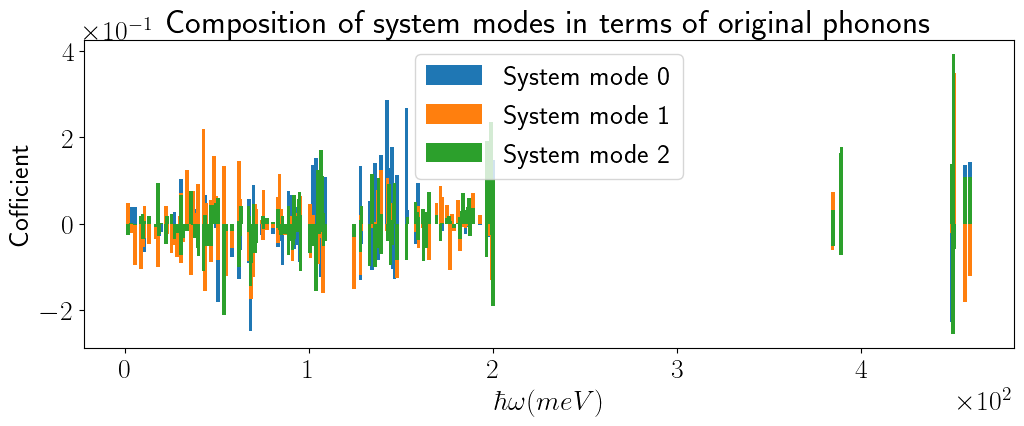

In [81]:
plt.figure(figsize=(12,4))
for i in range(len(Ks)):
    plt.bar(freq,np.squeeze(Ks[i].full().real), width=2)

plt.title(r"Composition of system modes in terms of original phonons")
plt.xlabel(r"$\hbar \omega (meV)$")
plt.ylabel(r"Cofficient")
#plt.yscale('log')
plt.legend(['System mode 0','System mode 1','System mode 2'])
plt.show()

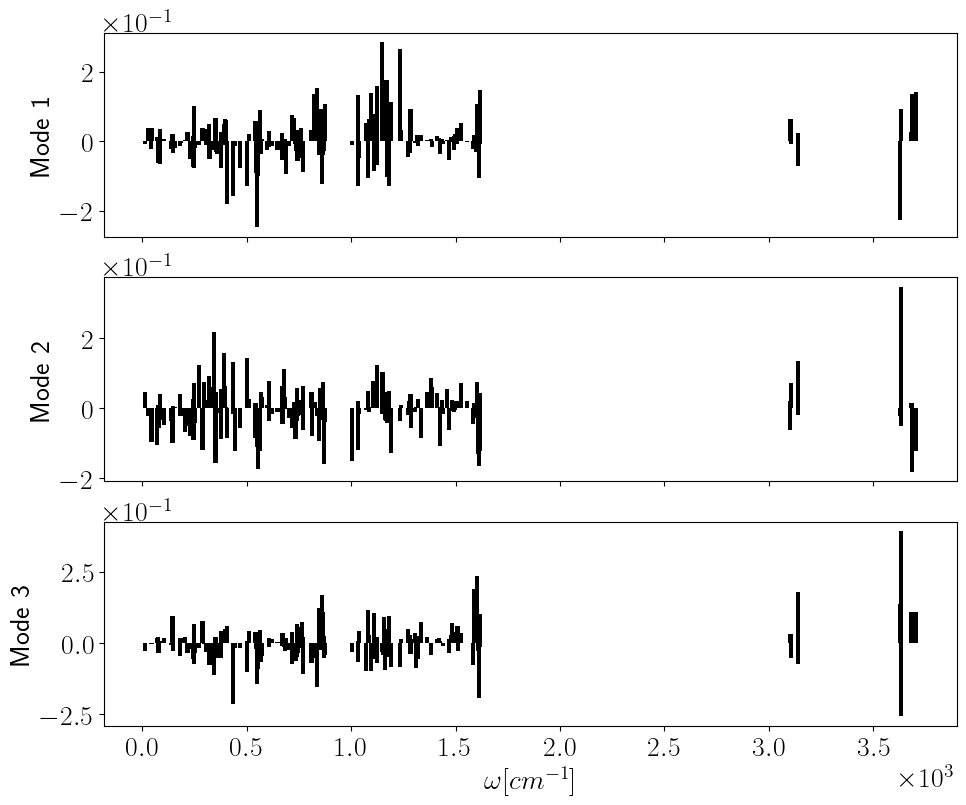

In [82]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [1, 1,1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)

color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"Mode 1", color='k')
#axs[0].set_ylim([0, 5])
axs[0].bar(freq/cm2mev,np.squeeze(Ks[0].full().real), width=20, color='k')
#axs[0].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor='k')

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{zz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############


color = 'tab:blue'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"Mode 2", color='k')
#axs[1].set_ylim([0, 5])
axs[1].bar(freq/cm2mev,np.squeeze(Ks[1].full().real), width=20, color='k')
#axs[1].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[1].tick_params(axis='y', labelcolor='k')

#ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{yz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


#############

color = 'tab:blue'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"Mode 3", color='k')
#axs[2].set_ylim([0, 5])
axs[2].bar(freq/cm2mev,np.squeeze(Ks[2].full().real), width=20, color='k')
#axs[2].fill_between(xspec/cm2mev, np.array(yspec), 0, color='blue', alpha=.1)
axs[2].tick_params(axis='y', labelcolor='k')

#ax2 = axs[2].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\partial g_{xz}/\partial \hat x_k|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(freq[:highfreq]/cm2mev, gnorm, width=2.5, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([0, 10])


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [83]:
np.squeeze(np.array([Ks[0].full(), Ks[1].full(),Ks[2].full()])).transpose().shape

(190, 3)

### Spectral Densities of projected and bath modes

In [84]:
Temp = 300

In [85]:
def spectral_density_coupled_modes_classical(w, gcoup, gamma_coup, omega_s, omega_b, T=10, sigma=2):
    '''
    Generates spectral density of system modes affecting the spin system. The system modes are coupled to the bath
    modes. The units of gcoup, gamma_coup, omega_s and omega_b should all be energy.
    The units of spectral density are Eng^2 s. Therefore, division by hbar^2 must be done afterwards.
    '''
    kB = 8.6173e-2 # meV/K, Boltzmann constant
    #gamma = 2 # dampng meV
    S = 0

    for r in range(len(omega_s)):
        for rp in range(len(omega_s)):
            wr = omega_s[r]/hbar # freq of system phonon r
            wrp = omega_s[rp]/hbar # freq of system phonon rp
            cr = gcoup[r]/(np.sqrt(hbar/wr)) # energy / length
            crp = gcoup[rp]/(np.sqrt(hbar/wrp)) # energy / length

            for j in range(len(omega_b)):
                wj = omega_b[j]/hbar # freq of bath phonons
                gamma = sigma #0.2*wj # dampng rate = 20 % of mode frequency
                grj = gamma_coup[r,j]/( np.sqrt(hbar/wr)*np.sqrt(hbar/wj) ) # energy/length^2
                grpj = gamma_coup[rp, j]/( np.sqrt(hbar/wrp)*np.sqrt(hbar/wj) )# energy/length^2
                factor1 = (wj**2 - w**2)**2 + (gamma**2)*(w**2)
                factor2 = (wr**2-w**2)*(wrp**2-w**2)
                S += (cr*crp)*(grj*grpj)*(2*gamma*kB*T)/(factor1*factor2)
                #S += (2*gamma*kB*T)/(factor1*factor2)
    return S

In [86]:
gnewX, gnewY, gnewZ

(array([-1.39585806e-04,  3.30461905e-05, -1.74199370e-04]),
 array([7.54098504e-05, 5.75508456e-05, 5.60214586e-05]),
 array([-1.62808697e-04,  9.41420530e-05,  1.19207561e-04]))

In [87]:
Temp=300
x = np.linspace(0,freq[-1], 1000)
#yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
#yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
yZ = [spectral_density_coupled_modes_classical(x/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp) for x in x]


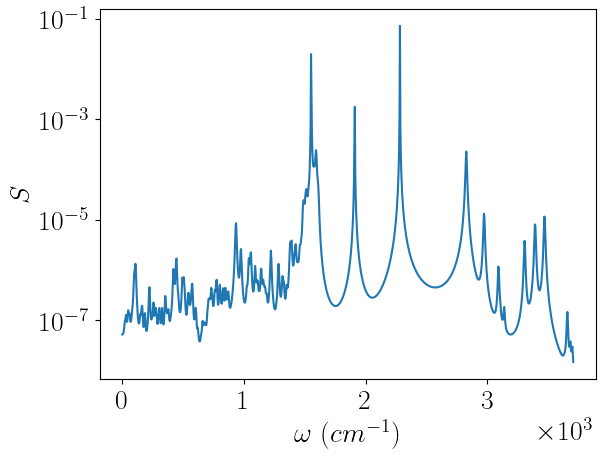

In [88]:
plt.figure()
#plt.plot(x/cm2mev,yX)
#plt.plot(x/cm2mev,yY)
plt.plot(x/cm2mev,yZ)
#plt.plot(omega_s/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_s[:165]], 'x')
#plt.plot(omega_b[:165]/cm2mev, [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, Temp) for x in omega_b[:165]], '.')
plt.yscale('log')
plt.ylabel(r"$S$")
plt.xlabel(r"$\omega\ (cm^{-1})$")
#plt.legend([r"$\sigma_x$", r"$\sigma_y$", r"$\sigma_z$"])
plt.show()

In [65]:
gamma_prime[2,:].shape

(187,)

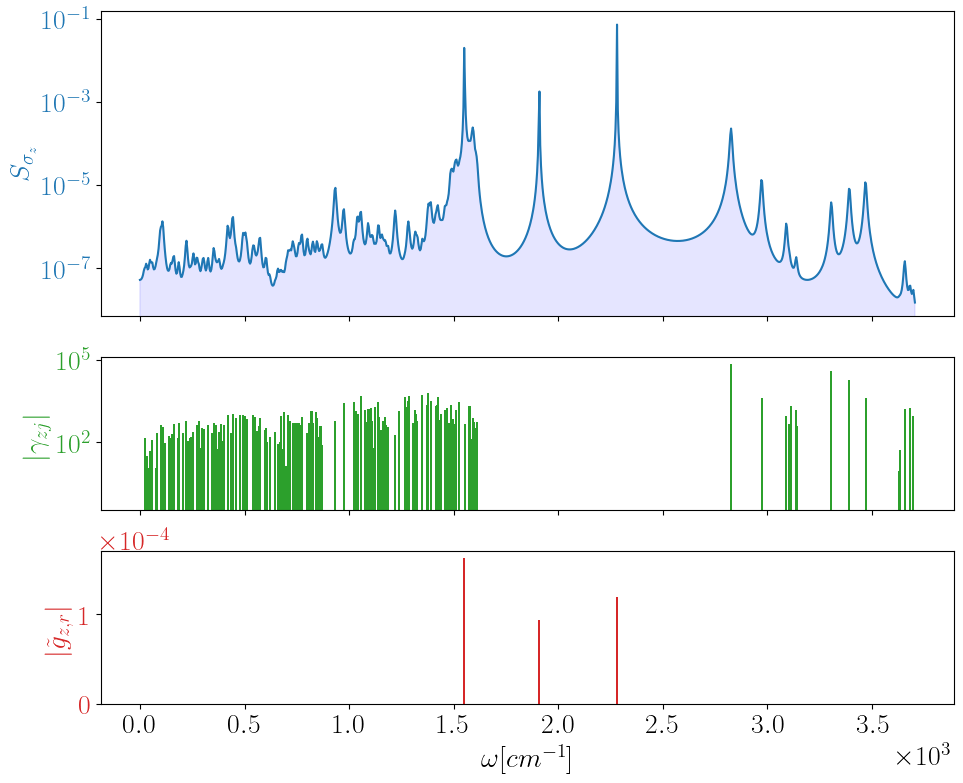

In [89]:
plt.rcParams['text.usetex'] = True 
plt.rcParams["axes.formatter.limits"]=(0,0)
plt.rcParams.update({'font.size': 20})

#fig, axs = plt.subplots(3, sharex=True)
fig, axs = plt.subplots(3,1,figsize=(11,9),sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
#fig = plt.figure(figsize=(7, 9))
#gs = fig.add_gridspec(3, hspace=0)
#axs = gs.subplots(sharex=True, sharey=False)


color = 'tab:blue'
axs[0].set_xlabel(r"$\omega [cm^{-1}]$")
axs[0].set_ylabel(r"$S_{\sigma_z}$", color=color)
#axs[0].set_ylim([0, 5])
axs[0].plot(x/cm2mev,np.array(yZ),color=color)
axs[0].fill_between(x/cm2mev, np.array(yZ), 0, color='blue', alpha=.1)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].set_yscale('log')

#ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
#ax2.set_ylabel(r"$|\gamma_{z,j}|$", color=color)  # we already handled the x-label with ax1
#ax2.set_yscale('log')
#ax2.bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_yscale('log')

#ax2.bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color='tab:black')
#############

color = 'tab:green'
axs[1].set_xlabel(r"$\omega [cm^{-1}]$")
axs[1].set_ylabel(r"$|\gamma_{zj}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[1].bar(omega_b/cm2mev, np.abs(gamma_prime[2,:]), width=10, color=color)
axs[1].tick_params(axis='y', labelcolor=color)
axs[1].set_yscale('log')

##############################


color = 'tab:red'
axs[2].set_xlabel(r"$\omega [cm^{-1}]$")
axs[2].set_ylabel(r"$|\tilde{g}_{z,r}|$", color=color)
#axs[0].set_ylim([0, 5])
axs[2].bar(omega_s/cm2mev, np.abs(gnewZ), width=10, color=color)
axs[2].tick_params(axis='y', labelcolor=color)
#axs[2].set_yscale('log')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [90]:
spectral_density_classical(w_split/hbar, freqs=freq, coup=gcoupS[:,2], T=5, sigma=2)/hbar**2

NameError: name 'w_split' is not defined

In [66]:
spectral_density_coupled_modes_classical(w_split/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=5)/hbar**2

NameError: name 'w_split' is not defined

In [ ]:
y = np.linspace(0,freq[-1], 1000)
#yX = [spectral_density_coupled_modes_classical(x/hbar,gnewX,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
#yY = [spectral_density_coupled_modes_classical(x/hbar,gnewY,gamma_prime,omega_s, omega_b, T=Temp) for x in x]
xZ = [spectral_density_coupled_modes_classical(y/hbar,gnewZ,gamma_prime,omega_s, omega_b, T=Temp) for y in y]


In [ ]:
## NOTE: need to add the movies of these modes from orca.

In [ ]:
print(gamma_prime.shape, gnewX.shape)

# Spin dyanmics after Mode Projection

### Method 4

Using Refield dyanmics wiht coupled oscillator spectral density

In [ ]:
1/np.pi

In [ ]:
np.sqrt(np.pi)

In [ ]:
np.sqrt(2/np.pi)

In [ ]:
np.sqrt(np.pi/2)

In [91]:
# Temperature Scan, multiple runs
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 3000e6, 1000) # in ps

In [96]:
t1_list_coupled = np.array([])
t1d_list_coupled = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    specDensityX = lambda w : 1.1*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : 1.1*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : 1.1*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp, sigma=2)/hbar**2
    
    #specDensityX = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewX, T=temp, sigma=2)/hbar**2
    #specDensityY = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewY, T=temp, sigma=2)/hbar**2
    #specDensityZ = lambda w : spectral_density_classical(w, freqs=omega_s, coup=gnewZ, T=temp, sigma=2)/hbar**2
    
    
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    print("temperature ", temp)
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    t1, t1d = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    t1_list_coupled = np.append(t1_list_coupled, t1)
    t1d_list_coupled = np.append(t1d_list_coupled, t1d)


#np.save('saved variables/t1_list_coupled', t1_list_coupled)
#np.save('saved variables/t1d_list_coupled', t1d_list_coupled)
print(t1_list_coupled)  

temperature  5
temperature  10
temperature  20
temperature  30
temperature  40
temperature  50
temperature  60
temperature  70
temperature  80
temperature  90
temperature  100
temperature  120
temperature  140
temperature  160
temperature  180
temperature  200
temperature  220
temperature  240
temperature  260
temperature  280
temperature  300
temperature  320
[289.15640383 144.57820248  72.28910175  48.19273484  36.14455141
  28.91564135  24.09636795  20.65402997  18.07227621  16.06424572
  14.45782055  12.04818446  10.32701487   9.03613796   8.03212291
   7.2289104    6.57173692   6.02409173   5.56070097   5.16350739
   4.8192744    4.51806938]


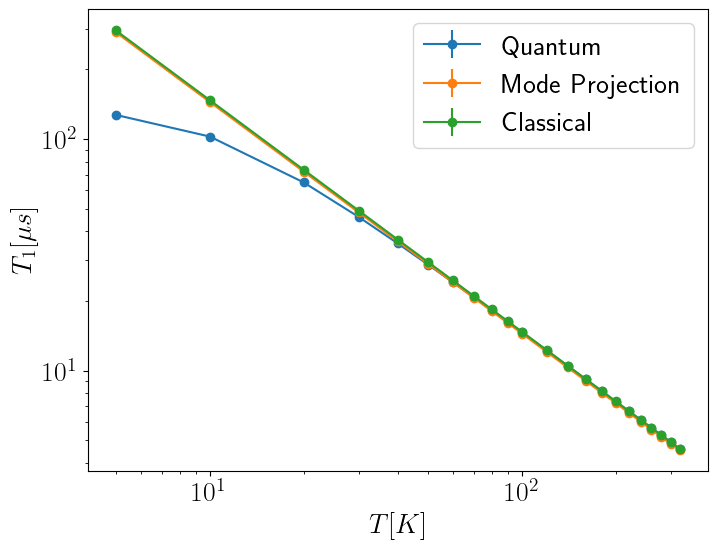

In [97]:
#t1_list_coupled = np.load('t1_list_coupled.npy')
#t1d_list_coupled = np.load('t1d_list_coupled.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend([r"Quantum", r"Mode Projection",r"Classical"])
plt.xlabel(r"$T [K]$")
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

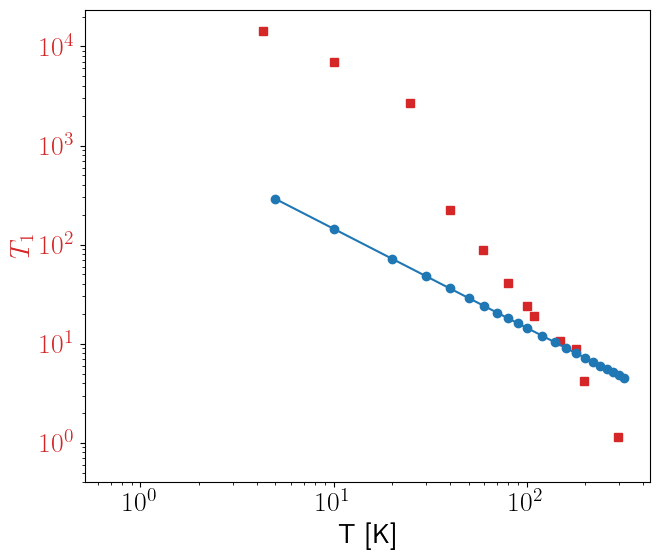

In [98]:
# adding the experimental data
t1exp = np.array([14163.72734, 6951.95423, 2691.61351,225.3970881,89.17022735,41.0253116,23.92805806,18.87486711,10.77391862,
                  8.873229094,4.171377424,1.143754573])
t2exp = np.array([2.709966603,3.084314127,3.362185823,3.290454844,3.018511437,2.829407455,2.540192367,2.330255261,2.047428917,
                  1.798929603,1.449961246, 0.84569149])
temp_exp = np.array([4.292624643, 9.998683733, 24.90051857, 39.95789327, 59.68654518, 79.87897033, 99.98683733, 109.4868393, 
                     149.3539422, 179.0832077, 198.9289628, 298.5702735])

t1_list_345mT = np.load('saved variables/t1_list_345mT.npy')
t1d_list_345mT = np.load('saved variables/t1d_list_345mT.npy')

#t2_list_345mT = np.load('t2_list_345mT.npy')
#t2d_list_345mT = np.load('t2d_list_345mT.npy')
t2_list_345mT = np.load('saved variables/t2_list.npy')
t2d_list_345mT = np.load('saved variables/t2d_list.npy')



fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$", color=color)
ax1.set_yscale('log')
ax1.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
ax1.plot(temp_exp, t1exp, 's', color=color)
ax1.tick_params(axis='y', labelcolor=color)


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel(r"$T_2$", color=color)  # we already handled the x-label with ax1
# #ax2.set_yscale('log')
# ax2.plot(Temp_list, t2_list_345mT, '-o',color=color)
# ax2.plot(temp_exp, t2exp, 's', color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
#t1_list_coupled = np.load('saved variables/t1_list_coupled.npy')
#t1d_list_coupled = np.load('saved variables/t1d_list_coupled.npy')
t1_list = np.load('saved variables/t1_list.npy')
t1d_list = np.load('saved variables/t1d_list.npy')
#t1_list_classical = np.load('saved variables/t1_list_classical.npy')
#t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list, yerr = t1d_list, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend([r"Quantum", r"Mode Projection",r"Classical"])
plt.xlabel(r"$T [K]$")
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

In [ ]:
rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
specDensityX = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
specDensityY = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
specDensityZ = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    

results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
t1, t1d = curve_fit(t1_func, tlist/1e6, np.abs(rho11_k))

print(t1, t1d)


#### T2 with mode projection

In [ ]:
# Temperature Scan 


tlist_t2 = np.linspace(1, 3e6, 10000) # in ps
rho0 = basis(2,0)*basis(2,1).dag()

t2_list_coupled = np.array([])
t2d_list_coupled = np.array([])

e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    
    temp = Temp_list[k]
    print("calculating t2 for ",temp, " K")
    
    specDensityX = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewX,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    specDensityY = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewY,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    specDensityZ = lambda w : 1*spectral_density_coupled_modes_classical(w,gnewZ,gamma_prime,omega_s, omega_b, T=temp)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    
    results_k = brmesolve(H/(hbar), rho0, tlist_t2, a_ops=aops, e_ops=e_ops)#, progress_bar=True)
    rho_list.append(results_k.states) # saving states for later
    rho12_k = np.array([results_k.states[j].full()[0,1] for j in range(len(tlist_t2))]) # first element of rho vs time 
    t2, t2d = curve_fit(t2_func, tlist_t2/1e6, np.abs(rho12_k))
    t2_list_coupled = np.append(t2_list_coupled, t2)
    t2d_list_coupled = np.append(t2d_list_coupled, t2d)


np.save('t2_list_coupled', t2_list_coupled)
np.save('t2d_list_coupled', t2d_list_coupled)
print(t2_list_coupled)  

rho12_vals = np.array([rho_list[-1][m].full()[0,1] for m in range(len(tlist_t2))])
rho21_vals = np.array([rho_list[-1][m].full()[1,0] for m in range(len(tlist_t2))])
fit = np.array([t2_func(k,t2_list[-1])  for k in tlist_t2/1e6])

plt.figure()
plt.plot(tlist_t2/1e6, np.abs(rho12_vals))
plt.plot(tlist_t2/1e6, np.abs(rho21_vals))
plt.plot(tlist_t2/1e6, fit)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$\rho$")
plt.title("Evolution of density matrix elements at "+str(Temp_list[-1])+"K , T2="+str(np.round(t2_list[-1],3)))
plt.legend([r"$\rho_{12}$", r"$\rho_{21}$", "fit"])
plt.show()

### Comparison with trivial cutoff

In [ ]:
# defining cutoff modes
def cutoff(gcoup, tol, freq):
    counter = 0
    gcoup_out = copy.deepcopy(gcoup)
    for i in range(len(gcoup)):   
        if np.abs(gcoup[i])<tol:
            gcoup_out[i] = 0
            counter += 1
        else:
            print("mode ", freq[i]/cm2mev, "with coupling ", gcoup[i], " passed")
    print('modes cut ', counter, ' , remaining', len(gcoup)-counter)
    return gcoup_out

In [ ]:
tol = np.max(gcoupS)*0.5# setting cutoff tolerance at 8% of max value
print("coupling through sigma X ")
gcoup_cut0 = cutoff(gcoupS[:,0], tol, freq)

print("coupling through sigma Y ")
gcoup_cut1 = cutoff(gcoupS[:,1], tol, freq)

#tol = np.max(gcoupS)*0.9
print("coupling through sigma Z ")
gcoup_cut2 = cutoff(gcoupS[:,2], tol, freq)

In [ ]:
freq[0]/cm2mev

In [ ]:
Temp_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320]
tlist = np.linspace(1, 300e6, 1000) # in ps

In [ ]:
t1_list_cut_classical = np.array([])
t1d_list_cut_classical = np.array([])

rho0 = basis(2,0)*basis(2,0).dag()
e_ops = []
rho_list = []

for k in range(len(Temp_list)):
    temp = Temp_list[k]
    #specDensityX = lambda w : spectral_density_classical(w, freqs=[freq[0]], coup=[gcoupS[0,0]], T=temp, sigma=2)/hbar**2
    specDensityX = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut0, T=temp, sigma=2)/hbar**2
    specDensityY = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut1, T=temp, sigma=2)/hbar**2
    specDensityZ = lambda w : spectral_density_classical(w, freqs=freq, coup=gcoup_cut2, T=temp, sigma=2)/hbar**2
    aops = [[sigmax(),specDensityX], [sigmay(),specDensityY], [sigmaz(),specDensityZ]]
    print('temperature', temp)
    results_k = brmesolve(H/(hbar), rho0, tlist, a_ops=aops, e_ops=e_ops)
    rho_list.append(results_k.states) # saving states for later
    rho11_k = np.array([results_k.states[j].full()[0,0] for j in range(len(tlist))]) # first element of rho vs time 
    t1, t1d = curve_fit(t1_func_classical, tlist/1e6, np.abs(rho11_k))
    t1_list_cut_classical = np.append(t1_list_cut_classical, t1)
    t1d_list_cut_classical = np.append(t1d_list_cut_classical, t1d)


np.save('saved variables/t1_list_cut_classical', t1_list_cut_classical)
np.save('saved variables/t1d_list_cut_classical', t1d_list_cut_classical)
print(t1_list_cut_classical)  

In [ ]:
t1_list_coupled = np.load('saved variables/t1_list_coupled.npy')
t1d_list_coupled = np.load('saved variables/t1d_list_coupled.npy')
t1_list_cut_classical = np.load('saved variables/t1_list_cut_classical.npy')
t1d_list_cut_classical = np.load('saved variables/t1d_list_cut_classical.npy')
t1_list_classical = np.load('saved variables/t1_list_classical.npy')
t1d_list_classical = np.load('saved variables/t1d_list_classical.npy')

plt.figure(figsize=(8,6))
plt.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o')
plt.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o')
plt.errorbar(Temp_list, t1_list_cut_classical, yerr = t1d_list_cut_classical, fmt='-o')


plt.xscale('log')
plt.yscale('log')
#plt.title(r"$T_1$ as a function of temperature for single molecule")
plt.legend(["Full Modes", "Mode Projection","Trivial Cutoff"])
plt.xlabel('T [K]')
plt.ylabel(r"$T_1 [\mu s]$")
plt.show()

In [ ]:

fig, ax1 = plt.subplots(figsize=(7,6))

color = 'tab:red'
ax1.set_xlabel('T [K]')
ax1.set_xscale('log')
ax1.set_ylabel(r"$T_1$ for Full Modes / Projected Modes")#, color=color)
ax1.set_yscale('log')
ax1.errorbar(Temp_list, t1_list_classical, yerr = t1d_list_classical, fmt='-o', color=color)
ax1.errorbar(Temp_list, t1_list_coupled, yerr = t1d_list_coupled, fmt='-o', color='tab:green')
ax1.tick_params(axis='y')#, labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"$T_1$ for Trivial Cutoff", color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.errorbar(Temp_list, t1_list_cut_classical, yerr = t1d_list_cut_classical, fmt='-o')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()


In [ ]:
omega_s/cm2mev

In [ ]:
np.array([170, 352, 533])*cm2mev

In [ ]:
gnewZ

In [ ]:
(-7.49 , -10.2, -3.16)